# Notebook evaluating metrics for particular node/edge configuration

In [38]:
# Installs 
#%pip install rioxarray xarray earthpy

# Package imports
import math
import json
import requests
import os
import ipyleaflet
import PIL
import numpy as np
import pandas as pd
import geopandas as gpd
import sklearn as skl
import rasterio as ro
import rioxarray as rxr
import xarray as xr
import earthpy as et
import seaborn as sns
import earthpy.plot as ep
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import matplotlib.cm as cm
from base64 import b64encode
from io import BytesIO
from tqdm import tqdm
from ipywidgets import HTML
from ipyleaflet import Map, basemaps, GeoData, CircleMarker, Popup, GeoJSON, LegendControl, ImageOverlay
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from rasterio.plot import show
from IPython.display import Image, display
from shapely.geometry import Polygon, Point, mapping

import descarteslabs as dl
import descarteslabs.workflows as wf

import netconf.netconf as nc

In [118]:
# Define variables
# Location variables
lat, lon, zoom = 33.893, 35.512, 14 # Map properties

# Building Footprints variables
buildings = "./data/beirutBuildingFootprints.geojson"

# Damage Assessment variables
dataFile = "./data/geopalData.csv" # GeoPal data

# Interferogram paths
ifgPath = "./data/20200730_20200805_IW1_Stack_ifg_deb_dinsar_flt_ML_TC_big.tif"
croppedPath = "./data/croppedIfg.png"

# A priori damage beliefs (green, yellow, red decisions)
gb, yb, rb = 0, 0.7, 1

# Edge creation
adjacent, ifgValues, neighbours = True, True, 10

# Train/test split
testSplit, dmgThresh, stdTest, randomState = 0.3, 0.5, False, 42

# Classifications
targets = ['Undamaged', 'Damaged']
decisions = {'GREEN (inspected) أخضر (تم دراسته)': False, 'YELLOW (restricted use) أصفر (لا يصلح للسكن)': True, 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء': True}

In [3]:
## Import Ground Data and combine
# Import footprints geojson
builds = gpd.read_file(buildings)
pd.set_option('display.max_columns', None)
fps = gpd.GeoDataFrame(builds[['id','building','name']], geometry=builds.geometry)

# Import GeoPal data
allData = pd.read_csv(dataFile)
# Extract locations from joint column in database
locations, mapPoints = allData['get location - الموقع_w_2049198'], allData['point on map - الموقع على الخريطة_w_2049199']
lats, lons = np.zeros([len(locations), 1]),  np.zeros([len(locations), 1])
for i in range(len(locations)):
    loc = locations[i]
    if type(loc) is float or (type(loc) is str and loc[0].isalpha()):
        mp = mapPoints[i]
        if type(mp) is str and mp[0].isdigit():
            try: lats[i], lons[i] = mp.split(' ')[0], mp.split(' ')[1]
            except: lats[i], lons[i] = mp.split(',')[0], mp.split(',')[1] # Deal with rogue commas instead of space
    else: lats[i], lons[i] = loc.split(' ')[0], loc.split(' ')[1]

# Extract columns of useful data
data = pd.DataFrame({
    'id': allData['Job ID'],
    'area': allData['plot area - المنطقة العقارية_w_2049201'],
    'damage': allData['structural damage level - مستوى الضرر الأنشائي للمبنى_w_2049205'],
    'floors': allData['number of floors - عدد الطوابق_w_2049208'],
    'units': allData['number of units - عدد الشقق_w_2049209'],
    'use': allData['building use - وجهة الاستعمال للمبنى_w_2049210'],
    'photos': allData['take pictures - التقاط صور_w_2049222'],
    'decision': allData['decision - القرار_w_2049224']    
})

# Create geodatabase merging locations with useful data
assessments = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(lons, lats),crs={'init': 'epsg:4326'})

# Filter for non located values
locs = assessments[assessments.geometry.x != 0]

# Get joint geodataframe of building footprints with damage assessments
joint = gpd.sjoin(fps, locs, how="left", op='contains').dropna(subset=['decision'])

def to_geodata(gdf, color):
    plotGdf = GeoData(geo_dataframe = gdf,
                          style={'color': color, 'radius':2, 'fillColor': color, 'opacity':0.9, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                          hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                          point_style={'radius': 3, 'color': color, 'fillOpacity': 0.8, 'fillColor': color, 'weight': 3},
                          name = 'Images')
    return plotGdf

m1 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'GREEN (inspected) أخضر (تم دراسته)'],'green'))
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'YELLOW (restricted use) أصفر (لا يصلح للسكن)'],'yellow'))
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء'],'red'))

if not 'l1' in globals(): # Add legend if forming map for first time
    l1 = legend = LegendControl({"No Restrictions":"#008000", "Restricted Use":"#FFFF00", "Unsafe/Evacuated":"#FF0000", "No Decision":"#0000FF"}, name="Decision", position="bottomleft")
    m1.add_control(l1)

# Display map upon which to draw Polygon for analysis
bd = joint.total_bounds
testPoly = ipyleaflet.Polygon(locations = [(bd[1]+0.012, bd[0]), (bd[1]+0.012, bd[2]-0.01), (bd[3], bd[2]-0.01),(bd[3], bd[0])], color="yellow", fill_color="yellow", transform=False if stdTest else True)

m1.add_layer(testPoly)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [115]:
## Get interferogram data and combine with ground data
# Import interferogram
wholeIfg = rxr.open_rasterio(ifgPath, masked=True).squeeze()
poly = Polygon([[p['lng'], p['lat']] for p in testPoly.locations[0]])
extent = gpd.GeoSeries([poly])
croppedIfg = wholeIfg.rio.clip(extent.geometry.apply(mapping), extent.crs)

# Create nodes
named = croppedIfg.rename('ifg')
df = named.to_dataframe()
coords = np.concatenate(np.array(df.axes[0]))
initial = gpd.GeoDataFrame(pd.DataFrame(np.concatenate((np.ones([len(df),2])*0.5, np.array(df['ifg']).reshape(-1,1)), axis=1), columns = ['noDmg','dmg','ifg']), geometry=gpd.points_from_xy(coords[1::2], coords[0::2]),crs={'init': 'epsg:4326'})

# Assign updated beliefs to pixels within assessed building footprints
X_train, X_test, y_train, y_test = train_test_split(joint[['geometry','decision']][joint.within(poly)], joint['decision'][joint.within(poly)], test_size=testSplit, random_state=42, shuffle=True, stratify = joint['decision'][joint.within(poly)])
nodes = gpd.sjoin(initial, X_train, how='left', op='within')
nodes = nodes[~nodes.index.duplicated(keep='first')]
nodes.loc[nodes.decision == 'GREEN (inspected) أخضر (تم دراسته)', ['noDmg', 'dmg']] = 1-gb, gb
nodes.loc[nodes.decision == 'YELLOW (restricted use) أصفر (لا يصلح للسكن)', ['noDmg', 'dmg']] = 1-yb, yb
nodes.loc[nodes.decision == 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء', ['noDmg', 'dmg']] = 1-rb, rb

# Create edges
edges = []

# Create edges between geographically adjacent nodes
if adjacent:
    x, l = len(df), len(nodes)
    for i in nodes.index:
        if not i % x == x-1: edges.append([i,i+1]) # Pixel to right (edge to left is equivalent to previous edge to right)
        if not i > l-x-1: edges.append([i,i+x]) # Pixel below (edge above is accounted for is equivalent to previous edge below)

# Create edges between most similar phase change pixels
if ifgValues:
    edges = edges + np.ndarray.tolist(np.array(kneighbors_graph(np.array(nodes.ifg).reshape(-1,1), neighbours, mode='connectivity', include_self=False).nonzero()).reshape(2,-1).transpose())

In [116]:
# Run belief propagation
priors = np.array(nodes[['noDmg','dmg']])
beliefs, _ = nc.netconf(np.array(edges),priors,verbose=True)

It	max{del(B)}	del(label)

0	4.67008e-01		19

1	1.95856e-01		10

2	1.03367e-01		10

3	5.23274e-02		9

4	2.99487e-02		8

5	1.74414e-02		8

6	1.05064e-02		8

7	6.64921e-03		166

8	4.14853e-03		322

9	2.70562e-03		440

10	1.73629e-03		698

11	1.13319e-03		817

12	7.35750e-04		891

13	4.80866e-04		1103

14	3.13851e-04		1204

15	2.05419e-04		1249

16	1.34438e-04		1410

17	8.81057e-05		1485



              precision    recall  f1-score   support

   Undamaged       0.98      0.91      0.94       326
     Damaged       0.00      0.00      0.00         6

    accuracy                           0.89       332
   macro avg       0.49      0.46      0.47       332
weighted avg       0.96      0.89      0.93       332



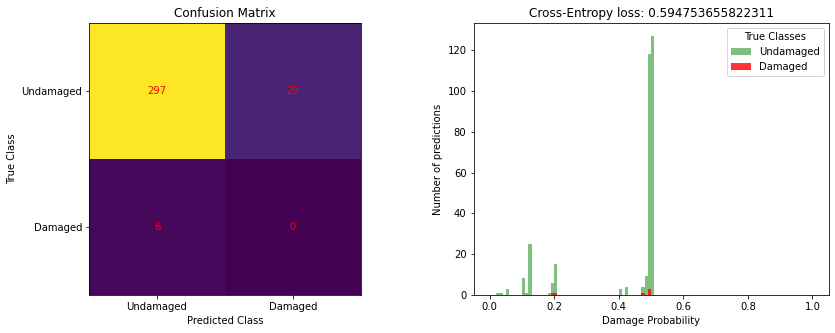

In [117]:
# Evaluation Metrics

# Get y_true vs y_pred for test set
y_true = gpd.sjoin(initial, X_test, how='left', op='within').dropna(subset=['decision']).decision.map(decisions)
y_pred =  skl.preprocessing.normalize(beliefs[y_true.index], norm='l1')[:,1]

# Classification metrics
ypClf = skl.preprocessing.binarize(y_pred.reshape(-1, 1), threshold=dmgThresh)
print(skm.classification_report(y_true, ypClf , target_names=targets, zero_division=0))

# Confusion matrix
fig, axs = plt.subplots(1,2, figsize=[14,5])
conf = skm.confusion_matrix(y_true, ypClf)
axs[0].imshow(conf, interpolation='nearest')
axs[0].set_xticks(range(len(targets))), axs[0].set_xticklabels(targets), axs[0].set_yticks(range(len(targets))), axs[0].set_yticklabels(targets)
axs[0].set_xlabel('Predicted Class'), axs[0].set_ylabel('True Class'), axs[0].set_title('Confusion Matrix')
for i in range(len(targets)): 
    for j in range(len(targets)): text = axs[0].text(j, i, conf[i, j], ha="center", va="center", color="r")
        
# Cross entropy / Confidence metrics
axs[1].hist(y_pred[(np.array(1-y_true)*y_pred).nonzero()[0]], range = [0,1], bins = 100, label = targets[0], color = 'g', alpha = 0.5)
axs[1].hist(y_pred[(np.array(y_true)*y_pred).nonzero()[0]], range = [0,1], bins = 100, label = targets[1], color = 'r', alpha = 0.8)
axs[1].set_title('Cross-Entropy loss: {}'.format(skl.metrics.log_loss(y_true, y_pred)))
axs[1].legend(title='True Classes', loc='upper right'), axs[1].set_xlabel('Damage Probability'), axs[1].set_ylabel('Number of predictions')
plt.show()